In [18]:
from matplotlib import pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import ndimage
import re
import glob
import datetime
import os
import seaborn

from astropy.utils.data import get_file_contents
import astropy.units as u
from astropy.time import Time
from astropy.utils.console import ProgressBar
from astropy.stats import sigma_clipped_stats
from astropy.io import fits

from photutils import daofind

import pandas as pd

%matplotlib inline
plt.style.use('ggplot')
from IPython.utils import io

In [2]:
# Load the PANOPTES module dir
import sys
sys.path.append('../')

# For development
%load_ext autoreload
%autoreload 2

from panoptes.utils.images import *

INFO:PanoptesLogger:

INFO:PanoptesLogger:********************************************************************************
INFO:PanoptesLogger:

DEBUG:PanoptesLogger:Adding warning logging to: PanError
DEBUG:PanoptesLogger:Adding warning logging to: SerialData
DEBUG:PanoptesLogger:Adding warning logging to: PanStateMachine
DEBUG:PanoptesLogger:Adding warning logging to: WeatherStation
DEBUG:PanoptesLogger:Adding warning logging to: AbstractCamera
DEBUG:PanoptesLogger:Adding warning logging to: Observation
DEBUG:PanoptesLogger:Adding warning logging to: Target
DEBUG:PanoptesLogger:Adding warning logging to: Scheduler
DEBUG:PanoptesLogger:Adding warning logging to: Observatory
DEBUG:PanoptesLogger:Adding warning logging to: Panoptes
DEBUG:PanoptesLogger:Adding warning logging to: Messaging
DEBUG:PanoptesLogger:Adding warning logging to: EnvironmentalMonitor
DEBUG:PanoptesLogger:Adding warning logging to: Webcams
DEBUG:PanoptesLogger:Adding warning logging to: PanSensors


In [16]:
dir1 = '/var/panoptes/images/20151001/*.fits'

In [10]:
pixel_scale = ((206.265) * (4.3 * u.micron) / (85 * u.mm)).cgs * u.arcsecond
pixel_scale

<Quantity 0.010434582352941176 arcsec>

In [17]:
cr2_files = glob.glob(dir1)
cr2_files.sort()
cr2_files

['/var/panoptes/images/20151001/IMAGE_001.fits',
 '/var/panoptes/images/20151001/IMAGE_002.fits',
 '/var/panoptes/images/20151001/IMAGE_003.fits',
 '/var/panoptes/images/20151001/IMAGE_004.fits',
 '/var/panoptes/images/20151001/IMAGE_005.fits',
 '/var/panoptes/images/20151001/IMAGE_006.fits',
 '/var/panoptes/images/20151001/IMAGE_007.fits',
 '/var/panoptes/images/20151001/IMAGE_008.fits',
 '/var/panoptes/images/20151001/IMAGE_009.fits',
 '/var/panoptes/images/20151001/IMAGE_010.fits',
 '/var/panoptes/images/20151001/IMAGE_011.fits',
 '/var/panoptes/images/20151001/IMAGE_012.fits',
 '/var/panoptes/images/20151001/IMAGE_013.fits',
 '/var/panoptes/images/20151001/IMAGE_014.fits',
 '/var/panoptes/images/20151001/IMAGE_015.fits',
 '/var/panoptes/images/20151001/IMAGE_016.fits',
 '/var/panoptes/images/20151001/IMAGE_017.fits',
 '/var/panoptes/images/20151001/IMAGE_018.fits',
 '/var/panoptes/images/20151001/IMAGE_019.fits',
 '/var/panoptes/images/20151001/IMAGE_020.fits',
 '/var/panoptes/imag

In [31]:
def clip_image(data, box_width=200):
    """ Return a clipped portion of the image 
    
    Shape is a box centered around the middle of the data
    
    Args:
        box_width(int): Size of box width in pixels
        
    Returns:
    
    """
    # Get the center
    x_len, y_len = data.shape
    x_center = int(x_len / 2)
    y_center = int(y_len / 2)

    box_width = int(box_width / 2)
    
    center = data[x_center-box_width:x_center+box_width, y_center-box_width:y_center+box_width]
    
    return center

In [42]:
hdu_list = fits.open(cr2_files[1])
fits_data = hdu_list[0].data
clip_data = clip_image(fits_data)

In [43]:
print(fits_data.shape)
print(clip_data.shape)

(3476, 5208)
(200, 200)


In [44]:
mean, median, std = sigma_clipped_stats(clip_data, sigma=3.0)

In [46]:
print(mean, median, std)

2285.09 2285.0 73.5571


In [11]:
def compare_files(f0, f1, compare=False):
    pgm_00 = f0.replace('.cr2','.pgm')
    pgm_01 = f1.replace('.cr2','.pgm')    
    
    #if not os.path.exists(pgm_00):
    pgm_00 = cr2_to_pgm(f0)
    #else:
    #    print("Path exists, using {}".format(pgm_00))
                
    #if not os.path.exists(pgm_01):
    pgm_01 = cr2_to_pgm(f1)
    #else:
    #    print("Path exists, using {}".format(pgm_01))                

#    exif_00 = read_exif(pgm_00)
    exif_01 = read_exif(f1)    
    

    raw_data_00 = read_pgm(pgm_00)
    # print(raw_data_00)
    raw_data_01 = read_pgm(pgm_01)
    # print(raw_data_01)

    x0, y0 = measure_offset(raw_data_00,raw_data_01, box_width=200)

    fmt = '%a %b %d %H:%M:%S %Y'
    t = datetime.datetime.strptime(exif_01.get('Timestamp'), fmt)

    if compare:
        with io.capture_output() as captured:    
            !/var/panoptes/bin/measure_offset $f0 $f1 

        x1 = float(get_file_contents('xcent.txt'))
        y1 = float(get_file_contents('ycent.txt'))
        
        vals = (x0, y0, x1, y1, t)
        
        
    else:
        vals = (x0, y0, t)

    return vals

In [ ]:
def field_offset(f0, f1):
    """ Compare the offset between two fields 
    
    Given two data sets that represent a star field, compute the offset between the two
    images.
    
    Args:
        f0()
    """

In [13]:
comparison = []

for i in np.arange(len(cr2_files)):
    if i < len(cr2_files) - 1:
        comparison.append(compare_files(cr2_files[i], cr2_files[i+1]))

In [14]:
comparison

[(-0.5, -0.5, datetime.datetime(2015, 9, 24, 7, 20, 46)),
 (-0.25, 0.0, datetime.datetime(2015, 9, 24, 7, 21, 34)),
 (1.0, -0.33333333333333331, datetime.datetime(2015, 9, 24, 7, 22, 23)),
 (1.25, 0.0, datetime.datetime(2015, 9, 24, 7, 23, 10)),
 (-0.13559322033898305,
  -0.2711864406779661,
  datetime.datetime(2015, 9, 24, 7, 25, 28)),
 (-1.1000000000000001, -0.375, datetime.datetime(2015, 9, 24, 7, 27, 45)),
 (0.5, -0.28846153846153844, datetime.datetime(2015, 9, 24, 7, 30, 4)),
 (0.40000000000000002,
  -0.32307692307692309,
  datetime.datetime(2015, 9, 24, 7, 32, 22)),
 (-0.5, -0.19444444444444445, datetime.datetime(2015, 9, 24, 7, 34, 39)),
 (-0.59999999999999998,
  -0.29999999999999999,
  datetime.datetime(2015, 9, 24, 7, 36, 58)),
 (0.86567164179104472,
  -0.34328358208955223,
  datetime.datetime(2015, 9, 24, 7, 39, 16)),
 (-0.25, -0.265625, datetime.datetime(2015, 9, 24, 7, 41, 33)),
 (-0.9178082191780822,
  -0.26027397260273971,
  datetime.datetime(2015, 9, 24, 7, 43, 51)),
 (0

In [17]:
x0 = [x[0] for x in comparison]
y0 = [x[1]*-1 for x in comparison]
#x1 = [x[2] for x in comparison]
#y1 = [x[3] for x in comparison]

dates = [x[-1] for x in comparison]
dt_index = pd.DatetimeIndex(dates)
dt_index

DatetimeIndex(['2015-09-24 07:20:46', '2015-09-24 07:21:34',
               '2015-09-24 07:22:23', '2015-09-24 07:23:10',
               '2015-09-24 07:25:28', '2015-09-24 07:27:45',
               '2015-09-24 07:30:04', '2015-09-24 07:32:22',
               '2015-09-24 07:34:39', '2015-09-24 07:36:58',
               '2015-09-24 07:39:16', '2015-09-24 07:41:33',
               '2015-09-24 07:43:51', '2015-09-24 07:46:10',
               '2015-09-24 07:48:28', '2015-09-24 07:50:46',
               '2015-09-24 07:53:04', '2015-09-24 07:55:21',
               '2015-09-24 07:57:40', '2015-09-24 07:59:57',
               '2015-09-24 08:02:15', '2015-09-24 08:04:33',
               '2015-09-24 08:06:51', '2015-09-24 08:09:09',
               '2015-09-24 08:11:27', '2015-09-24 08:13:45',
               '2015-09-24 08:16:03', '2015-09-24 08:18:22',
               '2015-09-24 08:20:39', '2015-09-24 08:22:57',
               '2015-09-24 08:25:16', '2015-09-24 08:27:34',
               '2015-09-

In [18]:
x0_offset = pd.DataFrame(x0, dt_index)
y0_offset = pd.DataFrame(y0, dt_index)
#x1_offset = pd.DataFrame(y1, dt_index)
#y1_offset = pd.DataFrame(x1, dt_index)

In [19]:
#series = pd.concat([x0_offset, x1_offset, y0_offset, y1_offset], axis=1)
#series.columns=["Gee $\Delta{x}$","Guyon $\Delta{x}$","Gee $\Delta{y}$","Guyon $\Delta{y}$"]

series = pd.concat([x0_offset, y0_offset], axis=1)
series.columns=["Gee $\Delta{x}$","Gee $\Delta{y}$"]

series.index = dt_index

In [20]:
series

,Gee $\Delta{x}$,Gee $\Delta{y}$
2015-09-24 07:20:46,-0.500000,0.500000
2015-09-24 07:21:34,-0.250000,-0.000000
2015-09-24 07:22:23,1.000000,0.333333
2015-09-24 07:23:10,1.250000,-0.000000
2015-09-24 07:25:28,-0.135593,0.271186
2015-09-24 07:27:45,-1.100000,0.375000
2015-09-24 07:30:04,0.500000,0.288462
2015-09-24 07:32:22,0.400000,0.323077
2015-09-24 07:34:39,-0.500000,0.194444
2015-09-24 07:36:58,-0.600000,0.300000


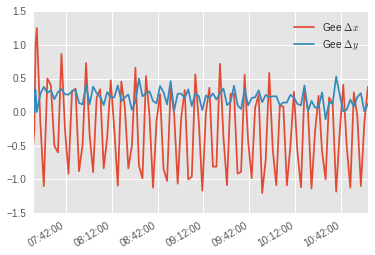

In [21]:
series.plot()
plt.legend(loc=1)